In [86]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import pandas as pd
import random


Import mnist data and split into train and test sets

In [87]:
seed = 10
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [88]:
# Define the architecture by modifying resnet.
# Original code is here http://tiny.cc/8zpmmz 
class ResNet101(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=True, **kwargs):
        # Start with the standard resnet101
        super().__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 23, 3],
            num_classes=num_classes,
            **kwargs
        )
        if pretrained:
            state_dict = load_state_dict_from_url(
                models.resnet.model_urls['resnet101'],
                progress=True
            )
            self.load_state_dict(state_dict)
 
    # Reimplementing forward pass.
    # Replacing the forward inference defined here 
    # http://tiny.cc/23pmmz
    def _forward_impl(self, x):
        # Standard forward for resnet
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        # Notice there is no forward pass through the original classifier.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
 
        return x


NameError: name 'models' is not defined

Now pass the data through the network and get the output of the last layer and plot the t-SNE plot

In [17]:
# train a simple resnet on MNIST

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from torchvision.datasets import MNIST




In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [44]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=64)

model = Net().to()
optimizer = optim.Adadelta(model.parameters(), lr=0.1)


In [35]:
# train
for epoch in range(1, 10 + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(), target.to()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

                

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.285794
Train Epoch: 1 [100/60000 (0%)]	Loss: 2.729947
Train Epoch: 1 [200/60000 (0%)]	Loss: 2.917753
Train Epoch: 1 [300/60000 (0%)]	Loss: 2.756327
Train Epoch: 1 [400/60000 (1%)]	Loss: 1.643221
Train Epoch: 1 [500/60000 (1%)]	Loss: 3.631297
Train Epoch: 1 [600/60000 (1%)]	Loss: 0.103122
Train Epoch: 1 [700/60000 (1%)]	Loss: 0.584652
Train Epoch: 1 [800/60000 (1%)]	Loss: 1.147391
Train Epoch: 1 [900/60000 (2%)]	Loss: 1.220521
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.324049
Train Epoch: 1 [1100/60000 (2%)]	Loss: 0.786589
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.006930
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.659468
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.163507
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.399495
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.691015
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.046561
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.005960
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.246573
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.422772
Trai

KeyboardInterrupt: 

In [45]:
# test
# data = MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
# data_loader = DataLoader(data, batch_size=1000, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print(f'Accuracy: {100 * correct / total}')


KeyboardInterrupt: 

In [60]:
!export CUDA_VISIBLE_DEVICES=6

In [89]:
# tsne plot after training
features = []
labels = []
for x,y in train_loader:
    # get the output from the last fc layer
    # x=x.cuda()
    # y=y.cuda()
    x = model.conv1(x)
    x = F.relu(x)
    x = model.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = model.dropout1(x)
    x = torch.flatten(x, 1)
    x = model.fc1(x)
    x = F.relu(x)
    x = model.dropout2(x)
    # x = model.fc2(x)
    features.append(x)
    labels.append(y)




In [93]:
features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

features = features.view(features.shape[0], -1)
features = features.detach().numpy()
labels = labels.detach().numpy()


In [96]:
features.shape

(60000, 128)

In [94]:
features

array([[0.        , 0.32062262, 0.01134519, ..., 0.20037873, 0.        ,
        0.4160492 ],
       [0.        , 0.11928058, 0.        , ..., 0.25385562, 0.        ,
        0.81369305],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.41448   ],
       ...,
       [0.        , 0.        , 0.06167242, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.11261033, 0.        ,
        0.        ],
       [0.        , 0.35090718, 0.1154455 , ..., 0.        , 0.        ,
        0.5741097 ]], dtype=float32)

/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


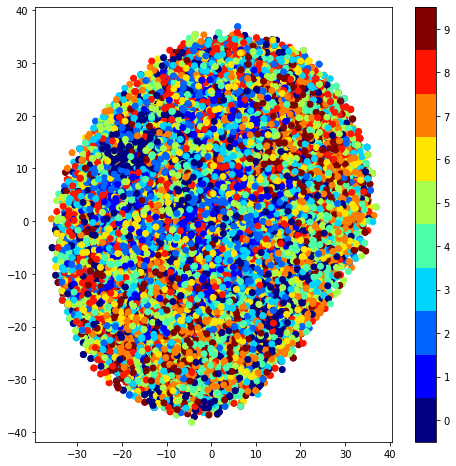

In [95]:
tsne = TSNE(n_components=2, random_state=0)
tsne_obj = tsne.fit_transform(features)
tsne_df = pd.DataFrame({'X': tsne_obj[:, 0], 'Y': tsne_obj[:, 1], 'label': labels})
fig = plt.figure(figsize=(8, 8))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['label'], cmap=cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()


In [67]:
features.shape

(60000, 10)

In [68]:
# data = MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
# data_loader = DataLoader(data, batch_size=1000, shuffle=False)

features1 = []
labels1 = []
for x, y in train_loader:
    features1.append(x)
    labels1.append(y)

features1 = torch.cat(features1, dim=0)
labels1 = torch.cat(labels1, dim=0)

features1 = features1.view(features1.shape[0], -1)
features1 = features1.numpy()
labels1 = labels1.numpy()


In [71]:
import torch.nn.functional as F
features1.shape

(60000, 784)

In [84]:
# features = transforms.ToTensor()(features)
outs=[]
total=0
correct=0
for x in features:
    y =  F.log_softmax(x, dim=1)
    _,y = torch.max(y.data,1)
    outs.append(y)
    total += y.size(0)
    correct += (predicted == y).sum().item()
# outs = torch.cat(outs, dim=0)
# outs = outs.numpy()


RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 0